In [0]:
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")

In [0]:
install.packages('keras')

In [0]:
library(keras)
library(tensorflow)

In [0]:
system("sudo apt-get install python-virtualenv")

In [0]:
install_tensorflow()

In [0]:
library(keras)

Fetching the Data from internal Keras Datasets.

In [0]:
cfr <- dataset_cifar10()

In [0]:
X_tr <- cfr$train$x
y_tr <- to_categorical(cfr$train$y, num_classes=10)

In [0]:
X_ts <- cfr$test$x
y_ts <- to_categorical(cfr$test$y, num_classes=10)

In [0]:
# Rescaling the data into the range 0 to 1
X_tr <- X_tr/255
X_ts <- X_ts/255

In [31]:
cat("Training X\t",dim(X_tr),"   Training y\t",dim(y_tr),"\n", "Testing X\t",dim(X_ts),"   Testing y\t",dim(y_ts))

Training X	 50000 32 32 3    Training y	 50000 10 
 Testing X	 10000 32 32 3    Testing y	 10000 10

###The Architecture of the Model

Convolution Layer (with activation "Relu")  --------> Convolution Layer (with activation "Relu") -----------> Max Pooling Layer (with 26 % dropout)  --------------> Convolution Layer(with activation "Relu") --------> Convolution Layer (with activation "Relu") -----------> Max Pooling Layer (with 26 % dropout)  ------------> Flattening Layer ------------> Dense Layer(with activation "Relu"  and 50% dropout) ---------------> Final Dense  Layer(with activation "SoftMax").      
  

In [0]:
model <- keras_model_sequential()

model %>% layer_conv_2d(filter=32, padding='same', input_shape=c(32,32,3), kernel_size=c(3,3)) %>%
          layer_activation("relu") %>%
          layer_conv_2d(filter=32, kernel_size=c(3,3)) %>%
          layer_activation("relu")%>%
          layer_max_pooling_2d(pool_size=c(2,2))%>%
          layer_dropout(0.26) %>%
          layer_conv_2d(filter=32, padding='same', kernel_size=c(3,3)) %>%
          layer_activation("relu")%>%
          layer_conv_2d(filter=32, kernel_size=c(3,3)) %>%
          layer_activation("relu") %>%
          layer_max_pooling_2d(pool_size=c(2,2)) %>%
          layer_dropout(0.26) %>%
          layer_flatten() %>%
          layer_dense(512) %>% 
          layer_activation("relu") %>%
          layer_dropout(0.5) %>%
          layer_dense(10) %>%
          layer_activation("softmax")

In [0]:
opt <- optimizer_adam(lr=0.0001, decay=1e-6)

In [0]:
model %>% compile(loss='categorical_crossentropy', optimizer = opt, metrics="accuracy")

In [102]:
#Summary of the model
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 32, 32, 32)              896         
________________________________________________________________________________
activation (Activation)             (None, 32, 32, 32)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 30, 30, 32)              9248        
________________________________________________________________________________
activation_1 (Activation)           (None, 30, 30, 32)              0           
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 15, 15, 32)              0           
________________________________________________________________________________
dropout (Dropout)           

#### Training and Capturing the History

In [0]:
hist <- model %>% fit(X_tr, y_tr,
      batch_size=32,
      shuffle =TRUE,
      validation_data = list(X_ts, y_ts) )

In [104]:
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


#### Plot of the Training History

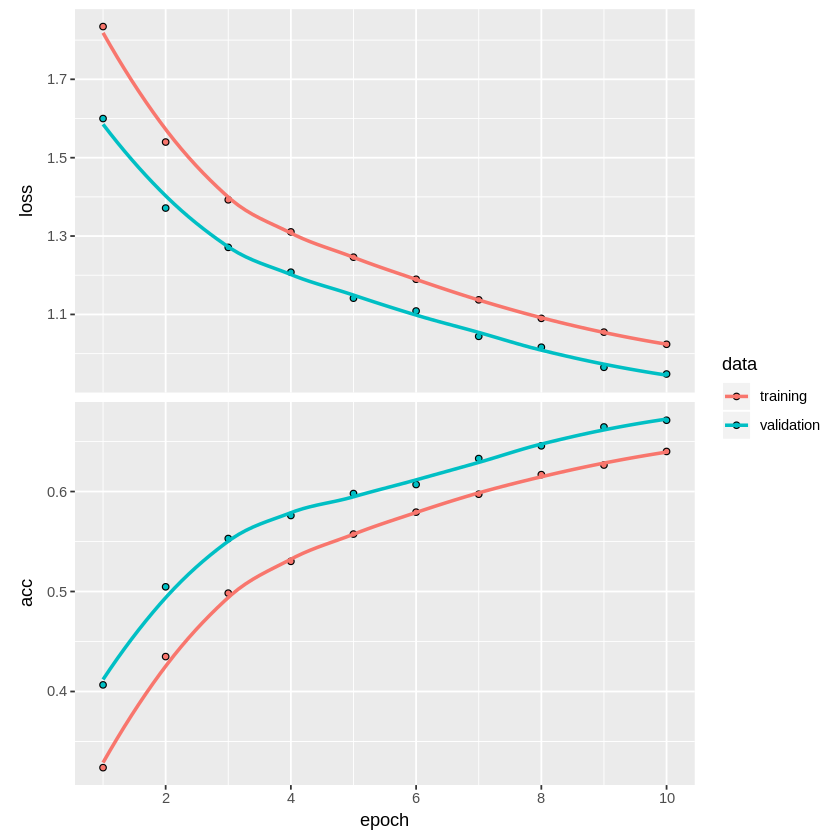

In [120]:
plot(hist, method = "ggplot2", theme_bw = getOption("keras.plot.history.theme_bw", FALSE))

#### Prediciton of the Classes

In [0]:
pred_class <- model %>% predict_classes(X_ts)

In [117]:
sum(cfr$test$y == as.matrix(pred_class)) /nrow(cfr$test$y)

[1] 0.6713

**The simple CNN gives as accuracy of over 67%. This can be further optimized by hyperparameter tuning.**

## Transfer Learning

Transfer Learning can be used for better prediction. Fine tuning of the predefined model is needed..

I am using VGG16 here. It is trained to predict one out of 1000 classes.  The output shape has to be 10.  The input shape has to be (32,32,3) instead of the regular (224,224,3) on which VGG16 is trained.

In [0]:
input_tensor <- layer_input(shape = c(32, 32, 3))

model_new <- application_vgg16(input_tensor = input_tensor, 
                                  weights='imagenet', 
                                  include_top = FALSE)

In [127]:
summary(model_new)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_3 (InputLayer)                (None, 32, 32, 3)               0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 (Conv2D)       

In [0]:
predictions <- model_new$output %>% 
  layer_global_average_pooling_2d() %>% 
  layer_dense(units = 256, activation = 'relu') %>% 
  layer_dense(units = 128, activation = 'relu') %>%
  layer_dense(units = 10, activation ='softmax')

The final needs to be stacked as a combination of the base model and new 10 output layer

In [0]:
model_tuned <- keras_model(inputs = model_new$input, outputs = predictions)

First of all, the entire VGG16 model should not be trained. The topmost layer (which has been changed from 1000 to 10) is to be trained.

In [0]:
freeze_weights(model_new)
model_tuned %>% compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics='accuracy')

In [0]:
model_tuned %>% fit(X_tr, y_tr,
      batch_size=32,
      shuffle =TRUE,
      validation_data = list(X_ts, y_ts) )

Now, as the topmost layer is trained well, the entire model or the latter part of it can be fine-tuned by training. I won't train the entire model as it will be time consuming.

In [133]:
layers <- model_new$layers
for (i in 1:length(layers))
  cat(i, layers[[i]]$name, "\n")

1 input_3 
2 block1_conv1 
3 block1_conv2 
4 block1_pool 
5 block2_conv1 
6 block2_conv2 
7 block2_pool 
8 block3_conv1 
9 block3_conv2 
10 block3_conv3 
11 block3_pool 
12 block4_conv1 
13 block4_conv2 
14 block4_conv3 
15 block4_pool 
16 block5_conv1 
17 block5_conv2 
18 block5_conv3 
19 block5_pool 


In [138]:
layers_entire <- model_tuned$layers
for(i in 1:length(layers_entire))
  cat(i, layers_entire[[i]]$name, "\n")

1 input_3 
2 block1_conv1 
3 block1_conv2 
4 block1_pool 
5 block2_conv1 
6 block2_conv2 
7 block2_pool 
8 block3_conv1 
9 block3_conv2 
10 block3_conv3 
11 block3_pool 
12 block4_conv1 
13 block4_conv2 
14 block4_conv3 
15 block4_pool 
16 block5_conv1 
17 block5_conv2 
18 block5_conv3 
19 block5_pool 
20 global_average_pooling2d 
21 dense_2 
22 dense_3 
23 dense_4 


I wil fine tune only from the 5th block onwards (layer 16 onwards)

In [0]:
freeze_weights(model_new, from = 1, to = 15)
unfreeze_weights(model_new, from = 16)

In [0]:
model_tuned %>% compile(
  optimizer = optimizer_sgd(lr = 0.0001, momentum = 0.9), 
  loss = 'categorical_crossentropy'
)

In [0]:
model_tuned %>% fit(X_tr, y_tr,
      batch_size=32,
      shuffle =TRUE,
      validation_data = list(X_ts, y_ts))

In [0]:
pred_class_new <- model_tuned %>% predict_classes(X_ts)

In [139]:
sum(cfr$test$y == as.matrix(pred_class)) /nrow(cfr$test$y)

[1] 0.9001

_The Accuracy drastically increases here due to Transfer Learning. A better fine-tuning can help to increase the accuracy._